In [44]:
from __future__ import print_function
import matplotlib.pyplot as plt
import glob
from itertools import chain
import os
import random
import zipfile
plt.style.use("ggplot")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT
import seaborn as sns   #←これを追加
import timm    #←これを追加
from albumentations.core.transforms_interface import DualTransform

from efficientnet_pytorch import EfficientNet

from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.augmentations import functional as F
from PIL import Image, ImageOps, ImageEnhance

In [45]:
class CFG:

                       # No. of epochs for training the model
  # Training settings
  batch_size = 25
  epochs = 20
  lr = 3e-5
  gamma = 0.7
  seed = 42                      # Batch Size for Dataset

#   model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
  IMG=224
  img_size = (IMG,IMG)                        # Resize all the images to be 224 by 224
  
  # going to be used for loading dataset
  ds_path = "/root/meidai/data/imgB/ABC20220706-1"




# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device on which we are:{}".format(device))

device on which we are:cuda


In [46]:

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CFG.seed)


In [47]:
from pathlib import Path
labels = []
Base_dir=[]
import os
        

for category in ['A','B','C']:
    for p in os.listdir(os.path.join(CFG.ds_path, category)):
        f = Path(os.path.join(CFG.ds_path,category, p))
        Base_dir.append(str(f))
        labels.append(str(f.parent.stem))

In [48]:
class Dataset():
    def __init__(self, filelist, transform = None):
        self.filelist = filelist
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = self.filelist[index]
        img = Image.open(imgpath).convert(mode="RGB")

        if "A" in imgpath[-20:]:
            label = 0
        elif "B" in imgpath[-20:]:
            label = 1
        elif "C" in imgpath[-20:]:
            label=2

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

In [49]:
train_dir, test_dir = train_test_split(Base_dir, test_size=0.2,random_state=123,stratify=labels)

GridMask

In [50]:
class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = F.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

AugMix

In [51]:
def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.


def sample_level(n):
    return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

def normalize(image):
    """Normalize input image channel-wise to zero mean and unit variance."""
    return image - 127

def apply_op(image, op, severity):
    #   image = np.clip(image, 0, 255)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img)

def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1.):
    """Perform AugMix augmentations and compute mixture.
    Args:
    image: Raw input image as float32 np.ndarray of shape (h, w, c)
    severity: Severity of underlying augmentation operators (between 1 to 10).
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.
    Returns:
    mixed: Augmented and mixed image.
    """
    ws = np.float32(
      np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image).astype(np.float32)
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        for _ in range(depth):
            op = np.random.choice(augmentations)
            image_aug = apply_op(image_aug, op, severity)
        # Preprocessing commutes since all coefficients are convex
        mix += ws[i] * image_aug
#         mix += ws[i] * normalize(image_aug)

    mixed = (1 - m) * image + m * mix
#     mixed = (1 - m) * normalize(image) + m * mix
    return mixed


class RandomAugMix(ImageOnlyTransform):

    def __init__(self, severity=3, width=3, depth=-1, alpha=1., always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.severity = severity
        self.width = width
        self.depth = depth
        self.alpha = alpha

    def apply(self, image, **params):
        image = augment_and_mix(
            image,
            self.severity,
            self.width,
            self.depth,
            self.alpha
        )
        return image

In [52]:
import albumentations

In [53]:
train_transformer= albumentations.Compose([
    albumentations.OneOf([
        GridMask(num_grid=3, mode=0, rotate=15),
        GridMask(num_grid=3, mode=2, rotate=15),
    ], p=0.7),
    RandomAugMix(severity=4, width=3, alpha=1.0, p=0.7)
])
test_transformer= transforms.Compose([
    transforms.Resize(CFG.img_size),
    transforms.ToTensor(),
    # transforms.Normalize(mean,std)

])

In [54]:
train=Dataset(train_dir,train_transformer)
test=Dataset(test_dir,test_transformer)

In [55]:
# train_loader = DataLoader(dataset = train, batch_size=CFG.batch_size, shuffle=True ,num_workers=16,pin_memory=True)
# test_loader = DataLoader(dataset = test, batch_size=CFG.batch_size, shuffle=True,num_workers=16,pin_memory=True)

In [56]:
# efficient_transformer = Linformer(
#     dim=128,
#     seq_len=49+1,  # 7x7 patches + 1 cls-token
#     depth=12,
#     heads=8,
#     k=64
# )
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k',
 'crossvit_9_240',
 'crossv

In [57]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=3)
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,),

In [58]:
# model = ViT(
#     dim=128,
#     image_size=224,
#     patch_size=32,
#     num_classes=3,
#     transformer=efficient_transformer,
#     channels=3,
# ).to(device)

In [59]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=CFG.gamma)

In [60]:
import time
from tqdm import tqdm
import time
import copy

In [61]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [62]:
classes=['A','B','C']

In [63]:
vit_models=[]
for i in range(5):
    model.load_state_dict(torch.load(f'./weights2(acc72)/model_5e_{i}.pth'))
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    vit_models.append(model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


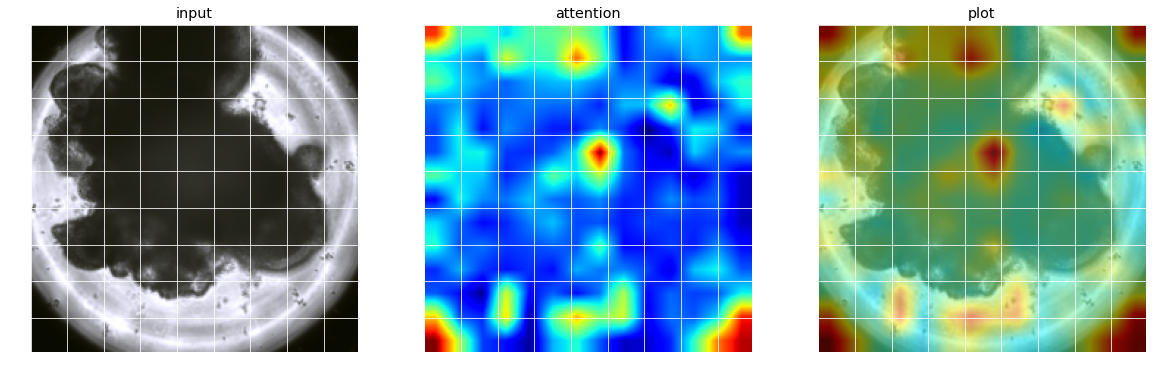

In [64]:
# 必要なモジュールをインポート 
import cv2
import timm
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms

from PIL import Image
from gradcam.utils import visualize_cam




# Attention Weightを取得するための関数 
def extract(pre_model, target, inputs):
    feature = None
    def forward_hook(module, inputs, outputs):
        # 順伝搬の出力を features というグローバル変数に記録する 
        global blocks
        blocks = outputs.detach()
    # コールバック関数を登録する
    handle = target.register_forward_hook(forward_hook) # 推論する
    pre_model.eval()
    pre_model(inputs)
    # コールバック関数を解除する
    handle.remove()
    return blocks
# ViTモデルを読み込む
model = vit_models[0]
model.to(device)
model.eval()

# blockごと(Transformer Encoderのlayer)のAttention Weightを取得 # L:層数, H:ヘッド数、N:パッチ数+クラストークン 
attention_weight = []
# 画像をリサイズしてセンタークロップ
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), normalize,])
invTrans = transforms.Compose([ transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.255]),])

# 画像ファイルを読み込み
#image = Image.open('/path/to/image')
image = Image.open('/root/meidai/data/imgB/ABC20220706-1/A/h27.20.tif').convert(mode="RGB")

x = transform(image) # shape :(3, 224, 224)
x = x.view(1, *x.shape) # shape :(1, 3, 224, 224)
for i in range(len(model.blocks)):
    target_module = model.blocks[i].attn.attn_drop
    features = extract(model, target_module, x.to(device)) # shape: (1, H, N, N)
    attention_weight.append([features.to('cpu').detach().numpy().copy()])
attention_weight = np.squeeze(np.concatenate(attention_weight), axis=1) # shape: (L, H, N, N)

# ヘッド方向に平均
mean_head = np.mean(attention_weight, axis=1) # shape: (L, N, N)
# NxNの単位行列を加算
mean_head = mean_head + np.eye(mean_head.shape[1])
# 正規化
mean_head = mean_head / mean_head.sum(axis=(1, 2))[:, np.newaxis, np.newaxis] # 層方向に乗算
v = mean_head[-1]
for n in range(1, len(mean_head)):
    v = np.matmul(v, mean_head[-1 - n])
# クラストークンと各パッチトークン間とのAttention Weightから、
# 入力画像サイズまで正規化しながらリサイズしてAttention Mapを生成
mask = v[0, 1:].reshape(14, 14)
attention_map = cv2.resize(mask / mask.max(), (x.shape[2], x.shape[3]))[..., np.newaxis]

# 入力画像を正規化前に戻す
inv_tensor = invTrans(x)[0]
# Attention MapとAttentionをかけた画像を生成
mask = torch.from_numpy(attention_map.astype(np.float32))
_, result = visualize_cam(mask, inv_tensor.to(device))

# 入力画像, Attention Map, Attentionをかけた画像を表示 
plt.figure(figsize=[20, 20])
plt.subplot(1, 3, 1)
plt.title('input')
plt.xticks(color="None")
plt.yticks(color="None")
plt.tick_params(length=0)
plt.imshow(inv_tensor.permute(1,2,0), vmin=0, vmax=1)

plt.subplot(1, 3, 2)
plt.title('attention')
plt.xticks(color="None")
plt.yticks(color="None")
plt.tick_params(length=0)
plt.imshow(attention_map, cmap='jet')

plt.subplot(1, 3, 3)
plt.title('plot')
plt.xticks(color="None")
plt.yticks(color="None")
plt.tick_params(length=0)
plt.imshow(result.detach().cpu().numpy().transpose(1, 2, 0))
# plt.savefig('./attention_rollout.png')
# plt.clf()


In [65]:

class VitAttention:
    def  __init__(self,vit_models) -> None:
        self.model = vit_models[0]
        self.model.to(device)
        self.model.eval()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
        self.transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), normalize,])
        self.invTrans = transforms.Compose([ transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.255]),])
    # Attention Weightを取得するための関数 
    def extract(self,pre_model, target, inputs):
        feature = None
        def forward_hook(module, inputs, outputs):
            # 順伝搬の出力を features というグローバル変数に記録する 
            global blocks
            blocks = outputs.detach()
        # コールバック関数を登録する
        handle = target.register_forward_hook(forward_hook) # 推論する
        pre_model.eval()
        pre_model(inputs)
        # コールバック関数を解除する
        handle.remove()
        return blocks
    
    def forward_hook(self,module, inputs, outputs):
        # 順伝搬の出力を features というグローバル変数に記録する 
        global blocks
        blocks = outputs.detach()
    def attention(self,file_dir):
        # blockごと(Transformer Encoderのlayer)のAttention Weightを取得 # L:層数, H:ヘッド数、N:パッチ数+クラストークン 
        attention_weight = []
        # 画像をリサイズしてセンタークロップ


        # 画像ファイルを読み込み
        #image = Image.open('/path/to/image')
        image = Image.open(file_dir).convert(mode="RGB")

        x = self.transform(image) # shape :(3, 224, 224)
        x = x.view(1, *x.shape) # shape :(1, 3, 224, 224)
        for i in range(len(self.model.blocks)):
            target_module = self.model.blocks[i].attn.attn_drop
            features = self.extract(self.model, target_module, x.to(device)) # shape: (1, H, N, N)
            attention_weight.append([features.to('cpu').detach().numpy().copy()])
        attention_weight = np.squeeze(np.concatenate(attention_weight), axis=1) # shape: (L, H, N, N)

        # ヘッド方向に平均
        mean_head = np.mean(attention_weight, axis=1) # shape: (L, N, N)
        # NxNの単位行列を加算
        mean_head = mean_head + np.eye(mean_head.shape[1])
        # 正規化
        mean_head = mean_head / mean_head.sum(axis=(1, 2))[:, np.newaxis, np.newaxis] # 層方向に乗算
        v = mean_head[-1]
        for n in range(1, len(mean_head)):
            v = np.matmul(v, mean_head[-1 - n])
        # クラストークンと各パッチトークン間とのAttention Weightから、
        # 入力画像サイズまで正規化しながらリサイズしてAttention Mapを生成
        mask = v[0, 1:].reshape(14, 14)
        attention_map = cv2.resize(mask / mask.max(), (x.shape[2], x.shape[3]))[..., np.newaxis]

        # 入力画像を正規化前に戻す
        inv_tensor = self.invTrans(x)[0]
        # Attention MapとAttentionをかけた画像を生成
        mask = torch.from_numpy(attention_map.astype(np.float32))
        _, result = visualize_cam(mask, inv_tensor.to(device))

        # 入力画像, Attention Map, Attentionをかけた画像を表示 
        # plt.figure(figsize=[20, 10])
        # plt.subplot(1, 3, 1)
        # plt.title('input')
        # plt.xticks(color="None")
        # plt.yticks(color="None")
        # plt.tick_params(length=0)
        # plt.imshow(inv_tensor.permute(1,2,0), vmin=0, vmax=1)

        # plt.subplot(1, 3, 2)
        # plt.title('attention')
        # plt.xticks(color="None")
        # plt.yticks(color="None")
        # plt.tick_params(length=0)
        # plt.imshow(attention_map, cmap='jet')

        # plt.subplot(1, 3, 3)
        # plt.title('plot')
        # plt.xticks(color="None")
        # plt.yticks(color="None")
        # plt.tick_params(length=0)
        tmp=result.detach().cpu().numpy().transpose(1, 2, 0)
        img_pil = Image.fromarray((tmp*255).astype(np.uint8))
        dir_path='./attention_images2/'+file_dir[37]
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        img_pil.save(dir_path+file_dir[38:])
        # plt.savefig(dir_path+file_dir[38:-4]+'.png')
        # plt.imshow(result.detach().cpu().numpy().transpose(1, 2, 0))
        # plt.clf()

    def main(self,dirs):
        for image in dirs:
            self.attention(image)

In [66]:
att=VitAttention(vit_models)

In [67]:
att.main(test_dir)

In [23]:
import os
import cv2
import torch
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from functools import partial
from baselines.ViT.ViT_explanation_generator import LRP_VIS


TypeError: forward() got an unexpected keyword argument 'method'

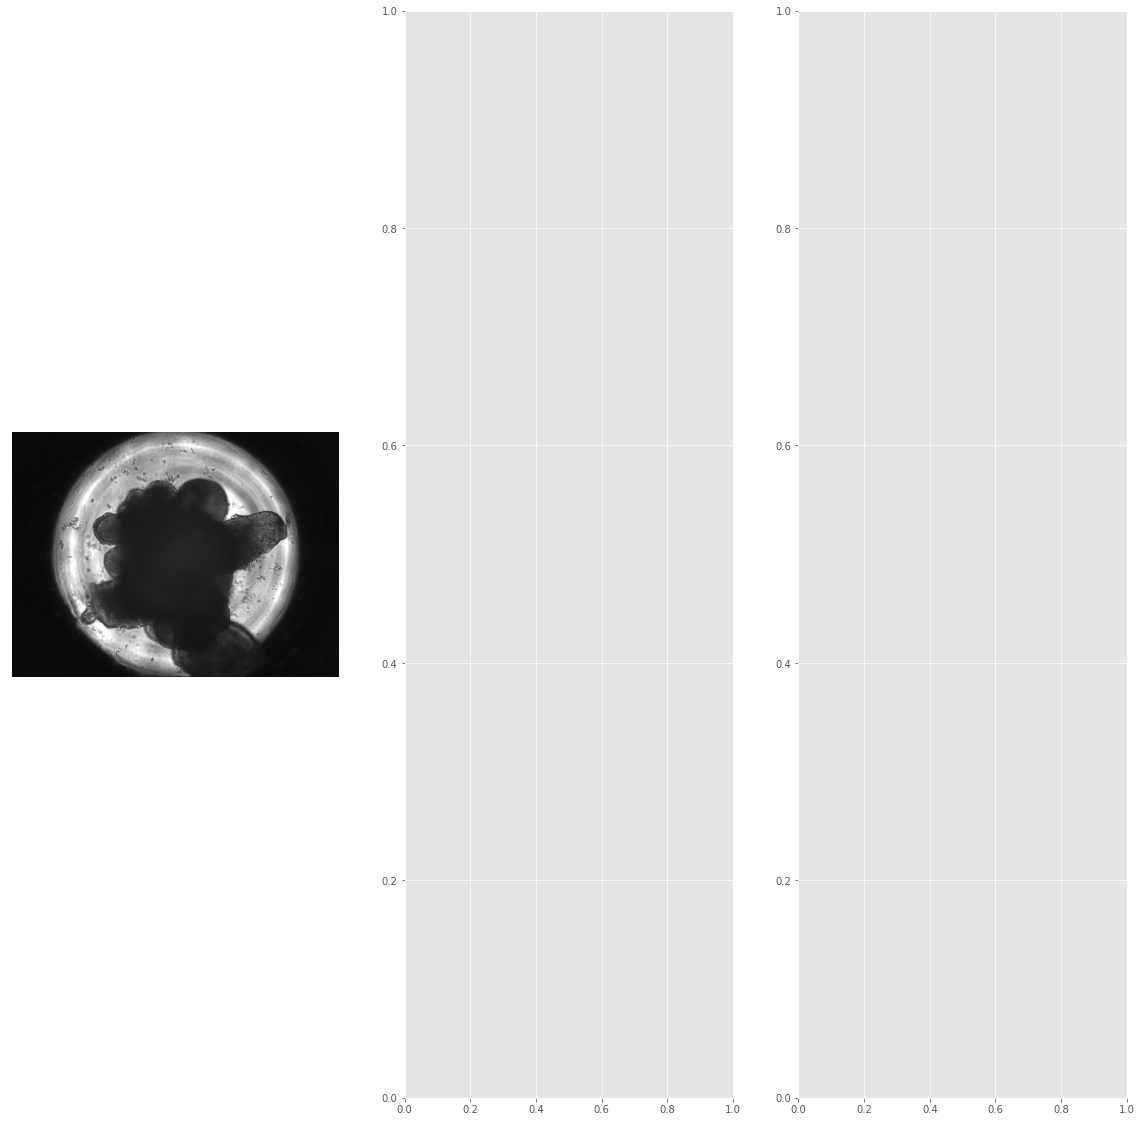

In [24]:


# 画像上のマスクからヒートマップを作成
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# Attention Weightを取得するための関数
def generate_visualization(original_image, class_index=None):
    # モデルの勾配とAttention RolloutからAttention Weightを求める
    # N:パッチ数 (196)
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach() # shape: (1, N)
    # 14x14にリサイズしてバイリニア補間しながらAttention Mapを可視化
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis
model=vit_models[0]

model.eval()
# モデルの勾配を求める
attribution_generator = LRP_VIS(model)

# 画像をリサイズしてセンタークロップ
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

########################################################################################################
# dog or cat
# 画像ファイルを読み込み、猫と犬のAttention Mapを可視化
image = Image.open('/root/meidai/data/imgB/ABC20220706-1/A/h27.12.tif').convert(mode="RGB")
cell_image = transform(image)

fig, axs = plt.subplots(1, 3, figsize=[20, 20])
axs[0].imshow(image);
axs[0].get_xaxis().set_visible(False);
axs[0].get_yaxis().set_visible(False);

output = model(cell_image.unsqueeze(0).cuda())

# 予測クラス:'Tiger cat' (クラス番号: 282). 下記他のcatのクラス番号一覧
# generate visualization for class 281: 'tabby cat'
# generate visualization for class 282: 'tiger cat'
# generate visualization for class 283: 'Persian cat'
# generate visualization for class 284: 'Siamese cat'
# generate visualization for class 285: 'Egyptian cat'
A = generate_visualization(cell_image, class_index=0)

# class_indexを変えることで、任意の対象クラスのAttention Mapを可視化可能
# 例えば、'Bull mastiff' (クラス番号: 243)のAttention Mapを可視化したい場合には、class_indexを243にする
# generate visualization for class 243: 'Bull mastiff'
# generate visualization for class 244: 'Tibetan mastiff'
# generate visualization for class 245: 'French bulldog'
B = generate_visualization(cell_image, class_index=1)

# 可視化
axs[1].imshow(A);
axs[1].get_xaxis().set_visible(False);
axs[1].get_yaxis().set_visible(False);
axs[2].imshow(B);
axs[2].get_xaxis().set_visible(False);
axs[2].get_yaxis().set_visible(False);
plt.savefig("./catdog.pdf")





In [ ]:
########################################################################################################
# zebra or elephant
# 画像ファイルを読み込み、シマウマと象のAttention Mapを可視化
image = Image.open('samples/el2.png')
tusker_zebra_image = transform(image)

fig, axs = plt.subplots(1, 3, figsize=[20, 20])
axs[0].imshow(image);
axs[0].get_xaxis().set_visible(False);
axs[0].get_yaxis().set_visible(False);

output = model(tusker_zebra_image.unsqueeze(0).cuda())

# 予測クラス:'zebra' (クラス番号: 340).
# generate visualization for class 340: 'zebra'
tusker = generate_visualization(tusker_zebra_image, class_index=340)

# class_indexを変えることで、任意の対象クラスのAttention Mapを可視化可能
# 例えば、'African elephant' (クラス番号: 386)のAttention Mapを可視化したい場合には、class_indexを386にする
# generate visualization for class 101: 'Tusker'
# generate visualization for class 385: 'Indian elephant'
# generate visualization for class 386: 'African elephant'
zebra = generate_visualization(tusker_zebra_image, class_index=101)

# 可視化
axs[1].imshow(tusker);
axs[1].get_xaxis().set_visible(False);
axs[1].get_yaxis().set_visible(False);
axs[2].imshow(zebra);
axs[2].get_xaxis().set_visible(False);
axs[2].get_yaxis().set_visible(False);
plt.savefig("./el2.pdf")